## pycity_base Tutorial

This is a tutorial on how to use pycity_base. 

pycity_base is a Python package for data handling and scenario generation of city districts and urban energy systems, developed by the Institute of Energy Efficient Buildings and Indoor Climate and the Institute of Automation of Complex Power Systems, E.ON Energy Research Center, RWTH Aachen University.


### Part 1: Buildings, apartments and loads

In [ ]:
(Nearly) every object within pycity_base requires a environment. The environment object holds general data, which are valid for all objects within the city, such as time and weather data or market prices.
Thus, all objects point to environment. Therefore, the first step is to generate an environment.

In [ ]:
import pycity_base.classes.timer as Timer
import pycity_base.classes.weather as Weather
import pycity_base.classes.prices as Prices
import pycity_base.classes.environment as Env

#   Generate timer object for environment
timer = Timer.Timer(time_discretization=3600, timesteps_total=8760)
#  Timer object holds timestep, number of timesteps as well as
#  forecast horizon

#  Generate weather object
weather = Weather.Weather(timer)
#  Weather object holds weather data, such as outdoor temperatures,
#  direct and diffuse radiation
#  Default TRY value is TRY2010_05_Jahr.dat
#  (Test reference year 2010 for region 5 in Germany)

#  Generate price object
price = Prices.Prices()
#  Holding energy prices and subsidies

#  Generate environment object
environment = Env.Environment(timer=timer, weather=weather, prices=price)

#  Now we got an environment with timer, weather and price data

#  Show current timestep
print('Time discretization in seconds:')
print(environment.timer.time_discretization)

#  Show weather forecast for outdoor temperature (only extract the first 10 timestep values)
print('\nShow outdoor tempreature forecast:')
print(environment.weather.getWeatherForecast(getTAmbient=True)[0][:10])

Time discretization in seconds:
3600

Show outdoor tempreature forecast:
[3.6 2.1 1.  0.1 0.  0.  0.2 0.1 0.1 0. ]


After defining the environment, we are going to generate load objects for an apartment

Space heating power curve in Watt:
[1894.03202642 1943.44155755 1992.85108867 ... 2483.68049022 1695.48051729
 1236.16974171]


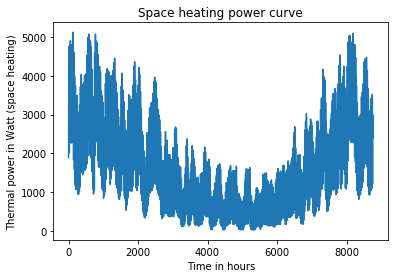

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pycity_base.classes.demand.domestic_hot_water as DomesticHotWater
import pycity_base.classes.demand.electrical_demand as ElectricalDemand
import pycity_base.classes.demand.space_heating as SpaceHeating

#  Generate space heating load object
space_heating = SpaceHeating.SpaceHeating(environment, method=1,
                                          living_area=150,
                                          specific_demand=100)
#  Method 1 --> Use standardized load profile (SLP)
#  Annual demand is calculated product of living_area and specific_demand

#  Show space heating power curve in Watt
print('Space heating power curve in Watt:')
print(space_heating.get_power(currentValues=False))
#  currentValues = False --> Show values for all timesteps
#  (not only for forecast horizon)

#  Plot curve
plt.plot(space_heating.get_power(currentValues=False))
plt.xlabel('Time in hours')
plt.ylabel('Thermal power in Watt (space heating)')
plt.title('Space heating power curve')
plt.show()

After generation a space heating load object, we will define an electrical load object

In [3]:
#  Generate electrical load object
el_demand = ElectricalDemand.ElectricalDemand(environment,
                                              method=1,
                                              annual_demand=3000)
#  Method 1 --> Use standardized load profile (SLP)

print('Electrical load in W:')
print(el_demand.get_power(currentValues=False))

Electrical load in W:
[316.028805 227.846295 174.312204 ... 552.381822 465.609927 354.624798]


Next, we generate a domestic hot water object, based on IEA Annex 42 data

In [4]:
#  Generate domestic hot water object via Annex 42 data
dhw_annex42 = DomesticHotWater.DomesticHotWater(environment,
                                                t_flow=60,
                                                thermal=True,
                                                method=1,
                                                daily_consumption=70,
                                                supply_temperature=25)
#  Method 1 --> Use Annex 42 data

print('Hot water power load in W:')
print(dhw_annex42.get_power(currentValues=False, returnTemperature=False))

Hot water power load in W:
[  0.           0.           0.         ... 244.64611111 108.09944444
   0.        ]


Now we generate an apartment object and add the loads to the apartment.

El. power curve of apartment in Watt:
[316.028805 227.846295 174.312204 ... 552.381822 465.609927 354.624798]


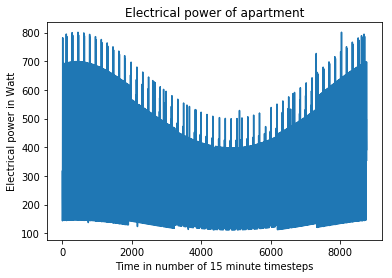

In [5]:
import pycity_base.classes.demand.apartment as Apartment

#  Initialize apartment object
apartment = Apartment.Apartment(environment)

#  Add single entity to apartment
apartment.addEntity(space_heating)

#  Add multiple entities to apartment
apartment.addMultipleEntities([el_demand, dhw_annex42])

el_power_curve = apartment.get_power_curves(getDomesticHotWater=False,
                                            getSpaceHeating=False,
                                            currentValues=False)[0]

print('El. power curve of apartment in Watt:')
print(el_power_curve)

#  Plot curve
plt.plot(el_power_curve)
plt.xlabel('Time in number of 15 minute timesteps')
plt.ylabel('Electrical power in Watt')
plt.title('Electrical power of apartment')
plt.show()

Next, we going to generate a building object and add our apartment to it.

Show space heating power curve of building
[1894.03202642 1943.44155755 1992.85108867 ... 2483.68049022 1695.48051729
 1236.16974171]
Show el. power curve of building
[316.028805 227.846295 174.312204 ... 552.381822 465.609927 354.624798]
Show domestic hot water power curve of building
[  0.           0.           0.         ... 244.64611111 108.09944444
   0.        ]


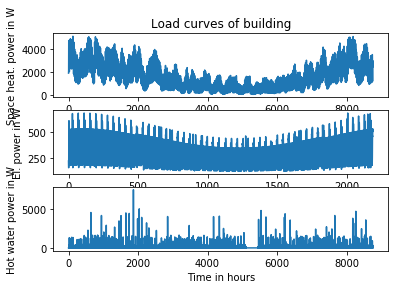

In [6]:
import pycity_base.classes.building as Building
from pycity_base.functions import change_resolution as chres

#  Initialize building object
building = Building.Building(environment)

#  Add apartment (with loads) to building object
building.addEntity(entity=apartment)

#  Return space heating power curve from building
print('Show space heating power curve of building')
space_heat_curve = building.get_space_heating_power_curve()
print(space_heat_curve)

#  Return el. power curve from building
print('Show el. power curve of building')
el_power_curve = building.get_electric_power_curve()
print(el_power_curve)

#  Return hot water power curve from building
print('Show domestic hot water power curve of building')
dhw_power_curve = building.get_dhw_power_curve()
print(dhw_power_curve)

#  Convert to identical timestep (of 3600 seconds)
el_power_curve_res = chres.changeResolution(el_power_curve, 900, 3600)

#  Plot all load curves
plt.subplot(3, 1, 1)
plt.title('Load curves of building')
plt.plot(space_heat_curve)
plt.ylabel('Space heat. power in W')

plt.subplot(3, 1, 2)
plt.plot(el_power_curve_res)
plt.ylabel('El. power in W')

plt.subplot(3, 1, 3)
plt.plot(dhw_power_curve)
plt.ylabel('Hot water power in W')
plt.xlabel('Time in hours')

plt.show()

pycity_base is also able to generate stochastic user profiles (instead of using standardized profiles). 
The stochastic occupancy profiles can be used to generate stochastic el. load and hot water profiles.

Occupancy profile:
[0 0 0 ... 2 1 1]
Maximum number of occupants:
3


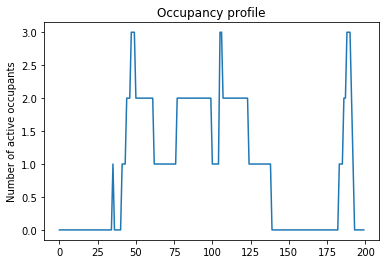

In [7]:
import pycity_base.classes.demand.occupancy as Occupancy

#  Generate stochastic occupancy object (with 3 occupants)
occupancy_object = Occupancy.Occupancy(environment, number_occupants=3)

#  Extract occupancy profile
occupancy_profile = occupancy_object.occupancy
print('Occupancy profile:')
print(occupancy_profile)

print('Maximum number of occupants:')
print(np.max(occupancy_profile))

plt.plot(occupancy_object.occupancy[:200])
plt.ylabel('Number of active occupants')
plt.title('Occupancy profile')
plt.show()

Based on the occupancy profile, we will generate a stochastic, el. load profile. 
This is going to take a couple of seconds.

In [8]:
#  Generate stochastic, electrical load object (time intensive calculation!)
el_dem_stochastic = \
    ElectricalDemand.ElectricalDemand(environment,
                                      method=2,
                                      total_nb_occupants=3,
                                      randomize_appliances=True,
                                      light_configuration=10,
                                      occupancy=occupancy_object.occupancy)
    
#  Get electric power curve
el_power_curve_stoch = el_dem_stochastic.get_power(currentValues=False)
print('Electric power curve in W:')
print(el_power_curve_stoch)

Electric power curve in W:
[ 47.          47.          47.         ... 746.75463685 782.76275598
 652.40803049]


Futhermore, we will generate a stochastic hot water power profile.

In [9]:
#  Generate stochastic, domestic hot water object
dhw_stochastical = \
    DomesticHotWater.DomesticHotWater(environment,
                                      t_flow=60,
                                      thermal=True,
                                      method=2,
                                      supply_temperature=20,
                                      occupancy=occupancy_object.occupancy)
    
#  Get dhw power curve
dhw_power_curve = dhw_stochastical.get_power(currentValues=False,
                                             returnTemperature=False)
print('Hot water power curve in W:')
print(dhw_power_curve)

Hot water power curve in W:
[  0.           0.           0.         ... 167.49078394  46.24646352
  81.02145348]


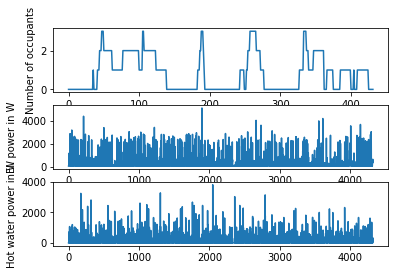

In [10]:
#  Plot all load curves
plt.subplot(3, 1, 1)
plt.plot(occupancy_object.occupancy[:432])
plt.ylabel('Number of occupants')

plt.subplot(3, 1, 2)
plt.plot(el_power_curve_stoch[:4320])
plt.ylabel('El. power in W')

plt.subplot(3, 1, 3)
plt.plot(dhw_power_curve[:4320])
plt.ylabel('Hot water power in W')

plt.show()

### Part 2: Building energy systems (BES)

We learned how to set up the demand/load part of a building object in part 1. Now we will learn how to define building energy systems and add them to a building.

The BES class is a 'container' for all kind of building energy systems. The BES container can be added to the building object.

In [11]:
import pycity_base.classes.supply.building_energy_system as BES
import pycity_base.classes.supply.boiler as Boiler

#  Initialize boiler object
boiler = Boiler.Boiler(environment, q_nominal=10000, eta=0.85)

# Initialize BES object
bes = BES.BES(environment)

#  Add device (boiler) to BES
bes.addDevice(boiler)

#  Use method getHasDevice to get info about boiler device
print('BES has boiler? (method getHasDevice): ', bes.getHasDevices(all_devices=False, boiler=True))
      
#  Or directly access attribute has_boiler
print('BES has boiler? (attribute has_boiler): ', bes.has_boiler)


BES has boiler? (method getHasDevice):  (True,)
BES has boiler? (attribute has_boiler):  True


In [12]:
#  If you like to access the boiler, you can it via BES attribute boiler, which holds the boiler object
print('bes.boiler attribute: ', bes.boiler)
print('bes.boiler.kind: ', bes.boiler[0].kind)

bes.boiler attribute:  [<pycity_base.classes.supply.boiler.Boiler object at 0x00000282CBBF9160>]


AttributeError: 'list' object has no attribute 'kind'

The same options are available for any other energy system. First, you have to initialize the energy system (such as CHP, HP or PV). Second, you have to add it to the BES. 

There are only two exceptions: PV- and Windfarms can also directly be placed on nodes within the city graph (will be shown later, when dealing with city district object).

Now we will add the BES to our building object

In [13]:
building.addEntity(entity=bes)

print('Does building have BES? ', building.has_bes)
print('Does building have apartment? ', building.has_apartment)
print('Does building have heating curve? ', building.has_heating_curve)

Does building have BES?  True
Does building have apartment?  True
Does building have heating curve?  False
